In [7]:
from IPython.display import Image, display

# Bayesian Synthetic Likelihood (BSL) 

**A mini sampling Framework in Python**

## I.Background on BSL

BSL is a recent method [Drovandi2018] that enables to sample from an **approximate posterior distributions** from model DGP's with **intractable likelihoods**.

\begin{align*}
p\left(\theta \mid y\right)  \propto \overbrace{p(y \mid \theta)}^\text{intractable} p(\theta) 
\end{align*}


Such models may be seen as "black boxes" that can generate different samples of simulated data for given input parameters (no knowledge of the likelihood function!):

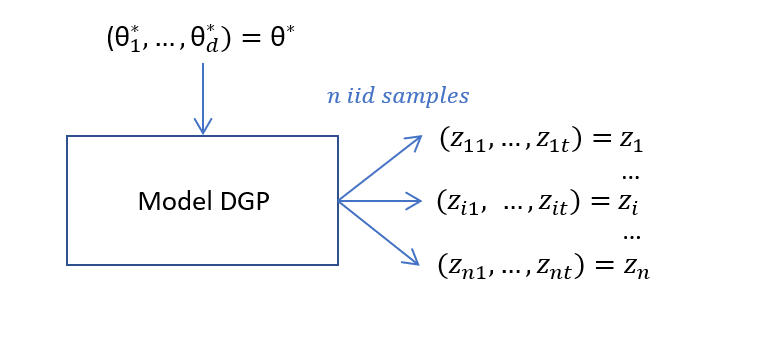

In [10]:
display(Image(filename='Images/DGP.png', embed=True))

### Approximation 1:
In order to circumvent a "curse-of-dimensionality" issue, BSL makes use of **summary statistics** instead of using the raw data. Therefore, BSL aims at sampling from:
\begin{align*}
p(\theta  \mid \boldsymbol{s_{y}}) \propto \overbrace{p\left(\boldsymbol{s_{y}} \mid \theta\right)}^\text{intractable} p(\theta)
\end{align*}

### Approximation 2: 
BSL  approximates the likelihood of the summary statistic, $p\left(s_{y} \mid \theta\right)$ with a **normal pdf**:
\begin{align*}
 p\left(s_{y} \mid \theta\right) \approx p_{A}\left(s_{y} \mid \theta\right) = \mathcal{N}\big(s_{y} ; \overbrace{\mu(\theta), \Sigma(\theta)}^\text{Unknown} \big) 
\end{align*}

### Approximation 3:
For a given $\theta^*$,  $\mu(\theta^*), \Sigma(\theta^*)$ can be estimated, yielding :
$\hat{p}(s_{y} \mid \theta^* ) = \mathcal{N}\left(s_{y} ; \mu_{\boldsymbol{n}}(\theta^*), \Sigma_{\boldsymbol{n}}(\theta^*)\right)$.

BSL uses this estimation within a **Pseudo-Marginal Metropolis Hastings (PMMH) algorithm** [AndrieuRoberts2009]  that targets: 


\begin{align*}
p_{A, n}\left(\theta \mid s_{y}\right) \propto &  \underbrace{p_{A, n}\left(s_{y} \mid \theta\right)} p(\theta)  \\
 & p_{A, n}\left(s_{y} \mid \theta\right)  = \mathbb{E}\big[\hat{p}(s_{y} \mid \theta ) \big] = \int_{\mathrm{S}^{n}} \mathcal{N}\left(s_{y} ; \mu_{n}(\theta), \Sigma_{n}(\theta)\right) \prod_{i=1}^{n} p\left(s_{i} \mid \theta\right) d s_{1: n} \neq p_{A}\left(s_{y} \mid \theta\right)
\end{align*} 

## II.The Algorihm

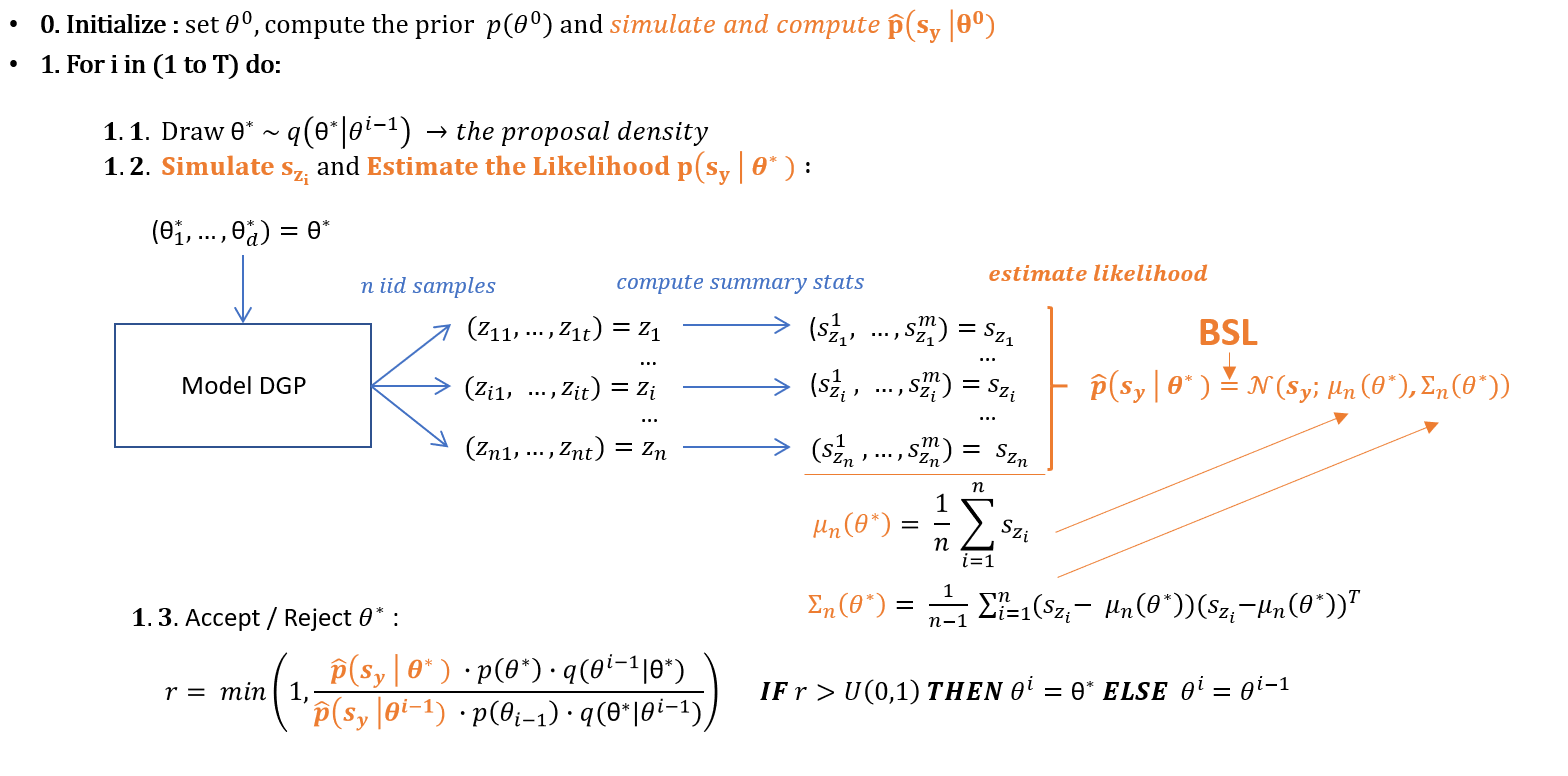

In [12]:
display(Image(filename='Images/Full_PMMH_2.png', embed=True))

## III. Implementation

**Presentation of a flexible framework to sample from BSL's approximate posterior**

The following code enables to sample from BSL's approximate posterior and allows the user to specify:
* the model to be simulated from
* the summary statistics to be taken into account
* the prior
* a number of parameters (e.g the scale parameters in the proposal distribution)

This is enabled by the following coding structure:

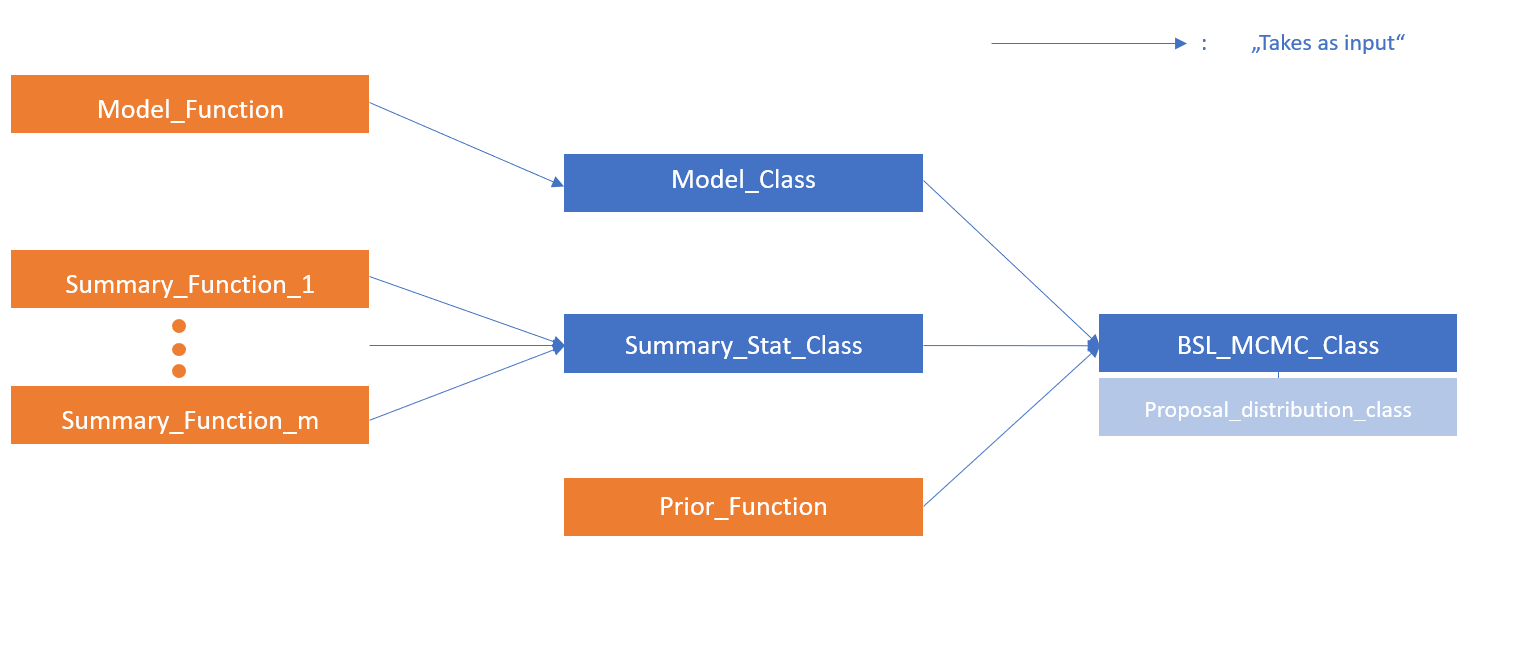

In [13]:
display(Image(filename='Images/Illustration code struktur.png', embed=True))


By this means it is possible to sample from BSL's approximate posterior. The final BSL_MCMC_Class also provides diagnostic  and plotting functions for the BSL results

**All functionnalities are Based on a small number of elementary packages:**

In [3]:
## Packages ###
#elementary mathematical / statistical operations:
import numpy as np
import numpy.random as rd
import scipy
import scipy.stats
import pandas as pd

#plotting:
import matplotlib.pyplot as plt
import seaborn as sns

#utility to see time per iteration:
from tqdm import tqdm

# to save results
import pickle 

### III. 1 The Model Class

The Model Class takes as initialization input:
* A **Model Function** specifying the underlying model which will make n simulations of size t 
* The **initial DGP-Model parameters** for later use in the BSL MCMC algorithm
* The **parameter names**

Once these have been set, the size of the simulations, **n** and **t** can be set via the **".set_simulation_size(t,n)"** method. 
Finally, one can simulate from the model via the **".simulate()"** method.

**Model Class:**

In [2]:
#Model class
class Model:
    def __init__(self, model_f, init_params, param_names):
        self.init_params = np.array(init_params)
        self.param_names =  param_names
        self.model= model_f
        
    def set_simulation_size(self, t, n):
        self.t = t
        self.n = n
        
    def simulate(self, params):
        return(self.model(params, self.n, self.t))

**Model Functions (others can be added):**

In [3]:
#Model function of interest: 
def Ricker_f(params, n, t): 
        #returns array with simulation data. 1 column per simulation, 1 row per observation
        N_t_matrix = [np.array([1]*n)]
        Poisson = []
        errors = rd.normal(0, params[1], t*n).reshape(t,n)
        for i in range(t):
            N_t_next = np.exp(params[0])*N_t_matrix[i]*np.exp(-N_t_matrix[i] + errors[i, :])
            N_t_matrix.append(N_t_next)
            Poisson.append(rd.poisson(lam= params[2]*N_t_next))
        return np.array(Poisson)
    
##following model not used here  
def MA_Model(params, n, t):
        #returns array with simulation data. 1 column per simulation, 1 row per observation
        w_t = np.array([0,0]*n).reshape([2, n])
        w_t = np.append(w_t, rd.normal(0, 0.1, t*n).reshape(t,n), axis = 0)
        coefs = np.array(params.copy())
        coefs = np.insert(coefs, 0, 1)
        output = np.apply_along_axis(lambda m: np.convolve(m,coefs, mode='valid'), axis=0, arr=w_t)   
        return np.array(output)

**DEMO:**      

In [4]:
#Define the model class: 
Ricker_Model = Model(model_f = Ricker_f, init_params=[2, 0.15, 15], param_names=["log(r)", "Sigma", "Phi"])
Ricker_Model.set_simulation_size(t = 50, n = 1000)
Ricker_data = Ricker_Model.simulate([3.8, 0.3, 10])        

In [5]:
# display the n simulations of length t
print(Ricker_data)

[[190 102 125 ... 177 114  72]
 [  0   0   0 ...   0   0   0]
 [  0   5   2 ...   0   0  27]
 ...
 [  1  64  15 ...  39   0   0]
 [102   4  98 ...  38   0   0]
 [  1 148   0 ...   9   0   0]]


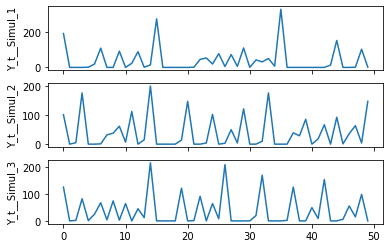

In [6]:
#plot the first 3 simulations:
Ricker_data_df =  pd.DataFrame(Ricker_data[:,:3], columns = ["Y_t__Simul_1", "Y_t__Simul_2", "Y_t__Simul_3"])
fig, axs = plt.subplots(nrows=3)
for i in range(3):
    sns.lineplot(ax = axs[i], data=Ricker_data_df["Y_t__Simul_"+ str(i+1)])
    if i < 2:
        axs[i].xaxis.set_ticklabels([])

### III. 2. The Summary Statistic Class

The **Summary statistics class** takes as input a number of **Summary Statistics Functions**. These functions can output either one (therefore a vector (n, 1), e.g for the mean) or k summary statistics per simulation (therefore a matrix of size (n, k), e.g Autoregression coefficients).

The summary statistic class enables to compute all these summary statistics "at once", via the **".compute()"** method.

**Summary Statistics Class**

In [7]:
class Summary_Stats:  
    
    def __init__(self, list_of_summary_stats_functions):
        self.list_of_summary_stats_functions = list_of_summary_stats_functions
        
    def compute(self, observations):
        return np.column_stack([function(observations) for function in self.list_of_summary_stats_functions]).T

**Summary Statistics Functions (add additional functions here in order to use in BSL):**

In [8]:
def Mean(observations):
   return np.mean(observations, axis= 0)

def Std(observations):
    return np.std(observations, axis= 0)

class Autocorrelation_k:

    def __init__(self, order):
        self.order = order
    
    def compute(self, observations): 
        #returns array with summary statistics. 1 column per simulation, 1 row per summary statistic
        observations = pd.DataFrame(observations)
        output = observations.apply(lambda x: x.autocorr(self.order), axis = 0).to_numpy()
        if np.isnan(output).any():
            raise ValueError('error')
        return  output if len(output) > 1 else output[0]

def N_Zeroes_Observed(observations):
    return observations.shape[0] - np.count_nonzero(observations, axis = 0)

# autoregression with "powers"
def autoregression_coefficients(observations):
    
    if observations.ndim == 1:
        Y = np.array([np.power(observations[1:], 0.3)]).T
        obs_t_1_to03 = np.power(observations[:-1], 0.3)
        obs_t_1_to06 = np.power(observations[:-1], 0.6)
        X = np.array([obs_t_1_to03, obs_t_1_to06]).T
        XTX = np.matmul(X.T,X)
        XTX_inv = np.linalg.inv(XTX)
        XTY = np.matmul(X.T,Y)
        Beta = np.matmul(XTX_inv, XTY)
        return(Beta.T)
        
        
    else:
        #create regression target variables in appropriate 3 matrix
        Y = np.array([np.power(observations[1:, :], 0.3)]).transpose(2,1,0)
        #create regression covariates
        obs_t_1_to03 = np.power(observations[:-1, :], 0.3)
        obs_t_1_to06 = np.power(observations[:-1, :], 0.6)
    
        #stack in 3d array
        X = np.array([obs_t_1_to03, obs_t_1_to06]).transpose(2,1,0)
    
        #create X'X and invert
        XTX = np.matmul(X.transpose(0,2,1),X)
        XTX_inv = np.linalg.inv(XTX)
    
        #create X'Y
        XTY = np.matmul(X.transpose(0,2,1),Y)

        #compute regression coefs Beta = inv(X'X).X'Y:
        Beta = np.matmul(XTX_inv, XTY)
        return(Beta[:,:,0])
    
def cubic_regression_coefficients(observations):
    if observations.ndim == 1:
        diff = (observations[1:] - observations[:-1]).T
        Y_t =  np.array([diff[1:]]).T
        ones = np.ones(diff.shape)[:-1]
        Y_t_1 = diff[:-1]
        Y_t_1_to2 = np.power(Y_t_1, 2)
        Y_t_1_to3 = np.power(Y_t_1, 3)
        X = np.array([ones, Y_t_1, Y_t_1_to2, Y_t_1_to3]).T
        XTX = np.matmul(X.T,X)
        XTX_inv = np.linalg.inv(XTX)
        XTY = np.matmul(X.T,Y_t)
        Beta = np.matmul(XTX_inv, XTY)
        return(Beta.T)
        
    else:
        #create regression target variables in appropriate 3 matrix
        diff = np.array(observations[1:, :] - observations[:-1, :])
        Y_t =  np.array([diff[1:,:]]).transpose(2,1,0)
        #create regression covariates
        ones = np.ones(diff.shape)[:-1, :]
        Y_t_1 = diff[:-1, :]
        Y_t_1_to2 = np.power(Y_t_1, 2)
        Y_t_1_to3 = np.power(Y_t_1, 3)
    
        #stack in 3d array
        X = np.array([ones, Y_t_1, Y_t_1_to2, Y_t_1_to3]).transpose(2,1,0)
    
        #create X'X and invert
        XTX = np.matmul(X.transpose(0,2,1),X)
        XTX_inv = np.linalg.inv(XTX)
    
        #create X'Y
        XTY = np.matmul(X.transpose(0,2,1),Y_t)

        #compute regression coefs Beta = inv(X'X).X'Y:
        Beta = np.matmul(XTX_inv, XTY)
        return(Beta[:,:,0])

**DEMO**

Create instance of summary stats:

In [9]:
Summary_Stats_names = ["Mean", "N_Zero"]+ ["cub_reg_coef" + str(i) for i in range(4)]+ ["autoreg_coef" + str(i) for i in range(2)] + ["Autocor_"+str(x) for x in range(1, 6)]
Summary_Stats_Instance = Summary_Stats([Mean, N_Zeroes_Observed, cubic_regression_coefficients, autoregression_coefficients] +[Autocorrelation_k(x).compute for x in range(1, 6)])


Compute with previously simulated data

In [10]:
#create summary stats for all n simulations (size: (n . k))
sum_stats_demo = Summary_Stats_Instance.compute(Ricker_data)

Plot

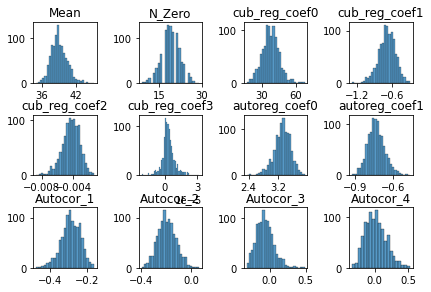

In [11]:
nrows= 3
ncols = 4
import matplotlib.ticker as ticker
fig, axs = plt.subplots(nrows=nrows, ncols = ncols)
fig.tight_layout()
index = np.array(list(range(nrows*ncols))).reshape(nrows,ncols)
for i in range(nrows):
    for j in range(ncols):    
        axs[i,j].locator_params(nbins=2)
        if index[i,j] <= 11:
            sns.histplot(data = sum_stats_demo[index[i,j],:], ax= axs[i, j] )
            axs[i,j].set_title(Summary_Stats_names[index[i,j]])
            axs[i,j].yaxis.set_label_text('')
            axs[i,j].xaxis.set_major_locator(ticker.MaxNLocator(1))
            axs[i,j].xaxis.set_minor_locator(ticker.MaxNLocator(1))
        else:
            axs[i,j].axis("off")
fig.savefig('distrib.pdf', format='pdf', bbox_inches='tight')

## III. 3. The Prior Function 

Not much to say here: The prior function should take a number of parameters equal to the pre-specified model. It outputs a scalar.
In the following only the improper prior used in the application is specified (if needed other priors could be specified here):

In [12]:
def Improper_Prior(x):
    #returns value of multivariate prior pdf at x
    prior_logr = 1
    prior_Sigma = 1 if x[1] > 0 else 0
    prior_Phi = 1 if x[2] > 0 else 0
    return prior_logr * prior_Sigma * prior_Phi

## III.4.  The BSL MCMC Class

The BSL_MCMC_Sampler takes 4 Initialization Inputs:
* **real_obs_a:** The true / observed data 
* **Model_c:** A Model_Class instance (already initialized, as in **I. Model_Class**)
* **summary_statistic_c** A Summary_Stats instance (already initialized, as in **II. Summary Statistics Class** )
* **prior_f:** A prior function (such as in **III. Prior Functions**) 

After initialization, one can sample from the approximate posterior via the **".sample(scaler_parameter, T, n)"** method, after having specifie the following parameters:

* **scaler_parameter**: covariance matrix of the proposal distribution (**NOTE:** the proposal distribution class is already defined  in the BSL_MCMC_sampler_class)
* **T:** Number of iterations
* **n:** Number of simulations per iteration

After sampling, one can use the following **plotting functions** provided as methods of the  **BSL_MCMC_Sampler_class**:
* **plot_posterior(self, burn_in = 0):** Enables to plot the posterior kernel density estimations
* **plot_trace():** Enables to plot the sampling trace

Finally, diagnostic values such as the **ESS**, the **normalized ESS** (see Price et. al 2018), or the **sampling rate** can be retrieved as attributes of the instantiated class.




In [13]:
class BSL_MCMC_sampler:
    
    def __init__(self,real_obs_a, Model_c, summary_statistic_c, prior_f):
        self.real_obs_a = real_obs_a
        self.Model_c = Model_c
        self.summary_statistic_c = summary_statistic_c
        self.prior_f= prior_f

    def density_estimation_f(self,observations): #see equation 3 in paper # observations by column
        mu = np.mean(observations, axis = 0)
        sigma = np.cov(observations.T, ddof =1) 
        density_estimate_f = scipy.stats.multivariate_normal(mu, sigma, allow_singular=True)
        return density_estimate_f   
    
    class proposal_distribution_class:
        def __init__(self, scale_parameter, theta_i_1):
            self.scale_parameter = scale_parameter
            self.theta_i_1       = theta_i_1
            self.theta_star      = rd.multivariate_normal(self.theta_i_1, self.scale_parameter)
        def theta_i_1_given_theta_star(self):
            return(scipy.stats.multivariate_normal(mean = self.theta_star, cov = self.scale_parameter).pdf(self.theta_i_1))
        def theta_star_given_theta_i_1(self):
            return(scipy.stats.multivariate_normal(mean = self.theta_i_1, cov =self.scale_parameter).pdf(self.theta_star))

    def sample(self,  scale_parameter, T, n):
        #length of observed data
        t = len(self.real_obs_a)
        self.scale_parameter = scale_parameter
        #set size of model simulations t:length of 1 series, n: number of iid simulations
        self.Model_c.set_simulation_size(t, n)
    
        theta_i_1 = self.Model_c.init_params
        sum_stat_theta_i_1 = self.summary_statistic_c.compute(self.Model_c.simulate(theta_i_1))
        thetas = [theta_i_1]
        count_acceptance = 0 # count number of times the sample got accepted
    
        for i in tqdm(range(T)):
            proposal_distribution = self.proposal_distribution_class(scale_parameter, theta_i_1)
            theta_star = proposal_distribution.theta_star

            #condition on theta star having non-zero probability --> we get reed of problems pertaining to the domain of definition of parameters (e.g Variance<0) 
            if self.prior_f(theta_star) > 0:
                try:
                    simulated_data = self.Model_c.simulate(theta_star)
                    sum_stat_theta_star = self.summary_statistic_c.compute(simulated_data)
                except: 
                    print("Warning: Error in the summary statistics computation. (likely cause: singular matrix in regression). Ignoring sample")
                else: 
    
                #compute approximate densities:
                    try:
                        density_estimate_theta_i_1 = self.density_estimation_f(sum_stat_theta_i_1.T).pdf(self.summary_statistic_c.compute(self.real_obs_a).T)
                        density_estimate_theta_star = self.density_estimation_f(sum_stat_theta_star.T).pdf(self.summary_statistic_c.compute(self.real_obs_a).T)
                    except: 
                        print("numerical issues - pdf returning value 0")
                    else:  
                    #compute priors' values:
                        prior_theta_i_1 = self.prior_f(theta_i_1)
                        prior_theta_star = self.prior_f(theta_star)
        
                    #compute values of proposal_disribution_f:
                        proposal_theta_star_given_theta_i = proposal_distribution.theta_star_given_theta_i_1()
                        proposal_theta_theta_i_given_star = proposal_distribution.theta_i_1_given_theta_star()
        
                    #compute r
                        joint_likelihood_ratio_nom = density_estimate_theta_star* prior_theta_star*proposal_theta_theta_i_given_star 
                        joint_likelihood_ratio_denom = density_estimate_theta_i_1* prior_theta_i_1*proposal_theta_star_given_theta_i
                        
                        if joint_likelihood_ratio_denom > 0 :
                            r = np.min([1, joint_likelihood_ratio_nom / joint_likelihood_ratio_denom])
                            
                        else:
                            #handle vanishingly small joint_likelihood_ratio_denom --> Numerical convenience
                            r = 1
                            print("Warning:"+str(i) +"r_denom has value 0 (due to approximation). The proposed parameter is skipped ")

                        if r > rd.uniform([0,1])[0]:
                            count_acceptance += 1
                            theta_i_1 = theta_star
                            sum_stat_theta_i_1 = sum_stat_theta_star
                            thetas.append(theta_i_1)

                        else:
                            thetas.append(theta_i_1)

            else:
                thetas.append(theta_i_1)
                    
                
        self.acceptance_rate = count_acceptance/(T) 
        self.drawn_samples = pd.DataFrame(data = thetas, columns = self.Model_c.param_names)
        self.plot_posterior()
        self.ESS_values = pd.DataFrame(data = self.drawn_samples.apply(lambda x: self.ESS_f(x)), index = self.Model_c.param_names, columns = ["ESS"])
        self.Adjusted_ESS_values = self.ESS_values / n
        self.Adjusted_ESS_values.columns = ["Adjusted_ESS_values"]
        print("Acceptance_Rate:" + str(self.acceptance_rate))
        print(self.Adjusted_ESS_values)
        print(self.ESS_values)
        
    #Compute Effective Sample Size 
    def ESS_f(self, samples, autocor_threshold= 0.05):
        autocorr_k = samples.autocorr(1)
        sum_autocorr = 0
        i = 1
        while autocorr_k > autocor_threshold:
            sum_autocorr += autocorr_k 
            i += 1
            autocorr_k = samples.autocorr(1+i)
        return(samples.shape[0] / (1 + 2*sum_autocorr ))
    
    #plot posterior density estimates
    def plot_posterior(self, burn_in = 0):
        df = self.drawn_samples.iloc[burn_in:]
        g = sns.PairGrid(df, diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15)
        g.map_lower(sns.kdeplot, fill =True)
        g.map_diag(sns.kdeplot, bw_adjust=2)
      
    #plot MCMC trace
    def plot_trace(self):
        sns.lineplot(data= self.drawn_samples)

**Note** Many warnings might appear. Those were put in the script on purpose in order to inform about numerical issues (e.g singular marices in the regressions which might appear by "chance". Or the denominator of r being equal to zero due to approximations). Whenever such warnings appear, the algorithm skips to the next sample. This should not impact the final sampling too strongly (if only occuring a small fraction of times).

**Results can be seen after warnings**

  0%|          | 6/5000 [00:00<07:35, 10.97it/s]

  0%|          | 8/5000 [00:00<06:38, 12.53it/s]

  0%|          | 12/5000 [00:00<06:16, 13.25it/s]

  0%|          | 14/5000 [00:00<06:57, 11.96it/s]

  0%|          | 18/5000 [00:01<07:40, 10.83it/s]

  0%|          | 20/5000 [00:01<07:48, 10.62it/s]

  0%|          | 24/5000 [00:01<08:03, 10.30it/s]

  1%|          | 27/5000 [00:02<08:32,  9.71it/s]

  1%|          | 30/5000 [00:02<08:43,  9.50it/s]

  1%|          | 33/5000 [00:02<08:30,  9.73it/s]

  1%|          | 35/5000 [00:03<08:28,  9.77it/s]

  1%|          | 39/5000 [00:03<08:32,  9.68it/s]

100%|██████████| 5000/5000 [07:03<00:00, 11.81it/s]


Acceptance_Rate:0.0892
        Adjusted_ESS_values
log(r)             0.939336
Sigma              1.522765
Phi                1.180775
              ESS
log(r)  46.966817
Sigma   76.138254
Phi     59.038748


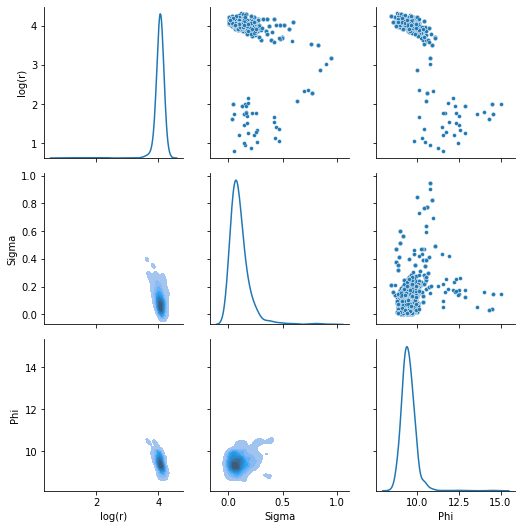

In [14]:
#simulate the true data (with length t = 200)
Ricker_Model.set_simulation_size(t = 50, n = 1)
y_data = Ricker_Model.simulate([3.8, 0.3, 10])    #define the true data

Ricker_Demo = BSL_MCMC_sampler(y_data, 
                               Ricker_Model, #defined in I. RECAL
                               Summary_Stats_Instance, # defined in II.
                               Improper_Prior) # defined in III.

scaling_parameter = [[0.05, 0, 0], [0, 0.01, 0],[0, 0, 0.25]]
Ricker_Demo.sample(scaling_parameter, T =5000, n = 50)

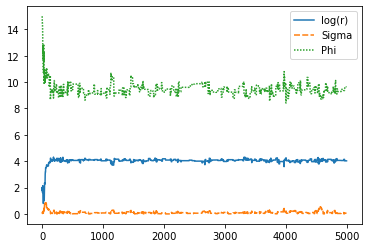

In [20]:
Ricker_Demo.plot_trace()

As can be seen below, the modes of the posterior densities' of the parameters of interest (log(r), Sigma and Phi) lie relatively close to the true parameter values (3.8 , 0.3 and 10). For computational reasons only 5000 iterations were performed, but improvment is expected for additional sampling (as can be seen furter below, the Effective sampling size is still below 100)

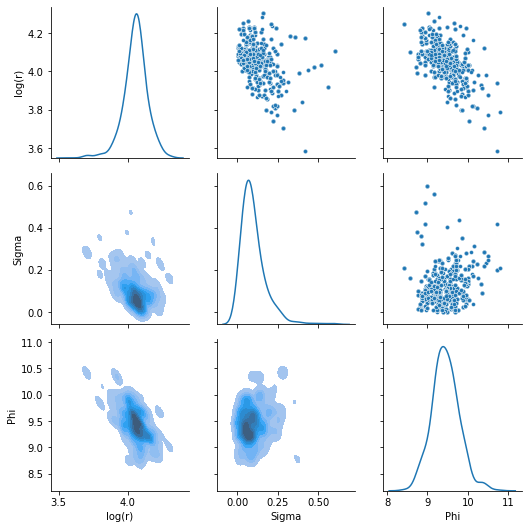

In [25]:
Ricker_Demo.plot_posterior(burn_in = 1000)

In [22]:
Ricker_Demo.ESS_values

,ESS
log(r),46.966817
Sigma,76.138254
Phi,59.038748


In [23]:
Ricker_Demo.Adjusted_ESS_values

,Adjusted_ESS_values
log(r),0.939336
Sigma,1.522765
Phi,1.180775


In [24]:
Ricker_Demo.acceptance_rate

0.0892

# References:
**Drovandi2018**: C. C. Drovandi et al. “Bayesian Synthetic Likelihood”. In: Journal of Computational and Graphical Statistics 27.1
(2018), pp. 1–11

**AndrieuRoberts2009**: C. Andrieu and G Roberts. “The Pseudo-Marginal Approach for Efficient Monte-Carlo Computations”. In: The
Annals of Statistics 37.2 (2009), pp. 697–725